$\newcommand{\cd}{\cdot}$
$\newcommand{\cs}{\cdots}$
$\newcommand{\dg}{^{\dagger}}$
$\newcommand{\fr}{\frac}$
$\newcommand{\nm}[1]{\left\lVert#1\right\rVert}$
$\newcommand{\ps}{\psi}$
$\newcommand{\px}[1]{\begin{pmatrix}#1\end{pmatrix}}$
$\newcommand{\qs}[1]{\left|#1\right>}$
$\newcommand{\sq}{\sqrt}$
$\newcommand{\te}{\theta}$
# Quantum-State-Preparation Circuit
## Input: $\psi\in\mathbb C^{2^n}$ s.t. $\nm\psi_2=1$.
## Output: $U:~\qs0_n~\mapsto\sum_{x=0}^{2^n-1}\psi_x\qs x_n,~x\in\mathbb F_2^n$.
### Induction:
#### n=1
$U_1=R_Y(\theta_0)$, where $R_Y(\theta)=S\cd H\cd R_Z(\theta)\cd H\cd S\dg,~S=P(\pi/2),~\theta_0=2\arccos(\psi_0)$.
#### n=2
$U_2=R_Y(\theta_{1\cd})\px{0\\R_Y(\theta_0)}$,
where $R_Y(\theta_{1\cd})=\px{0\\X}C_1R_Y(\theta_{10})\px{0\\X}C_1R_Y(\theta_{11})$,
$\te_0=2\arccos(\sq{\ps_{00}^2+\ps_{10}^2})$,
$\te_{10}=2\arccos(\fr{\ps_{00}}{\sq{\ps_{00}^2+\ps_{10}^2}})$,
$\te_{11}=2\arccos(\fr{\ps_{01}}{\sq{\ps_{01}^2+\ps_{11}^2}})$.
#### Suppose $U_k$ is a $k$-dimensional QSP gate, then $U_{k+1}=U_k(\ps_{k\cd})\px{0^k\\R_Y(\te_0)}$ and $\te_0=2\arccos(\nm{\ps_{(\cd)^k0}}_2)$,
where $U_k(\ps_{k\cd})=\px{0^k\\X}C_{k+1}U_k(\fr{\ps_{(\cd)^k0}}{\nm{\ps_{(\cd)^k0}}_2})
    \px{0^k\\X}C_{k+1}U_k(\fr{\ps_{(\cd)^k1}}{\nm{\ps_{(\cd)^k1}}_2})$,
    $\ps_{(\cd)^k0}$ denoting $(\ps_{0^k0},\cs,\ps_{1^k0})\in\mathbb C^{2^k}$, $0^k$ denoting $(0,\cs,0)\in\mathbb F_2^k$.

In [4]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import RZGate
from qiskit.quantum_info import Statevector, Operator
import numpy as np

We begin with the implementation of multi-controlled $R_Y$ via multi-controlled $R_Z$ and $1$-qubit gates.

CCRy(pi/3)=
[[ 1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.9+0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. -0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. -0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. -0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.5-0.j  0. +0.j  0. +0.j  0. +0.j  0.9+0.j]]


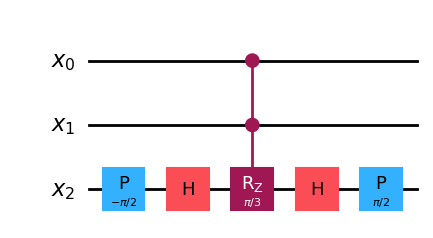

In [38]:
def mcry(circ, theta, cidx, tidx): # List of indices for controls, and index for target
    rz = RZGate(theta)
    if len(cidx) == 0:
        crz = rz # No-control case
    else:
        crz = rz.control(len(cidx))

    circ.p(-np.pi/2, tidx) # S dagger
    circ.h(tidx) # Hadamard
    circ.append(crz, cidx+[tidx])  # R_Z(theta) with controls
    circ.h(tidx) # Hadamard
    circ.p(np.pi/2, tidx) # S, here completes the decomposition of R_Y(theta)
# Since a QuantumCircuit is mutable, no return is needed.
x = QuantumRegister(size=3, name="x")
c = QuantumCircuit(x, name="mcryTest")
mcry(c, np.pi/3, [0,1], 2)
print('CCRy(pi/3)=')
print(np.round(Operator(c).data, 1))
c.draw(output="mpl")

[0.40824829+5.55111512e-17j 0.54772256-3.35383338e-17j
 0.73029674-4.83971535e-17j 0.        +0.00000000e+00j]


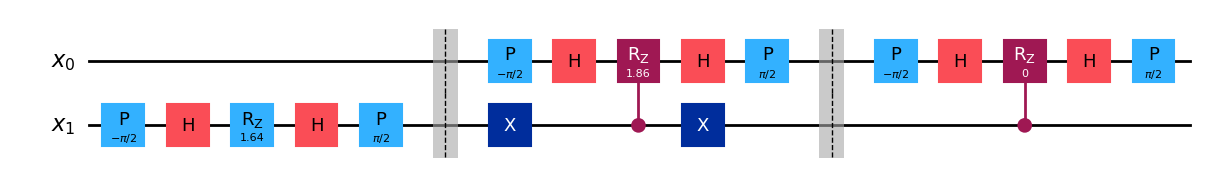

In [49]:
def induction(circ, psi, cidx, k): # Bottom-up Construction begining with control == [] and target == x[n-1]
    psi_0 = psi[:2^k]; norm_0 = np.linalg.norm(psi_0)
    theta_0 = 2*np.arccos(norm_0)
    if k==0: # Top layer
        mcry(circ, theta_0, cidx, 0)
    else:
        psi_1 = psi[2^k:]; norm_1 = np.linalg.norm(psi_1)
        mcry(circ, theta_0, cidx, k)
        circ.barrier()
        circ.x(k)
        induction(circ, [p/norm_0 for p in psi_0], cidx+[k], k-1)
        circ.x(k)
        circ.barrier()
        induction(circ, [p/norm_1 for p in psi_1], cidx+[k], k-1)
x = QuantumRegister(size=2, name="x")
c = QuantumCircuit(x, name="inductionTest")
induction(c, np.arange(1,5)/np.sqrt(30), [], 1)
print(Statevector(c).data)
c.draw(output="mpl")